# Clusterização

Selecionar os mais valiosos clientes para formar o programa de fidelidade.

**Conjunto de dados:** Foi utilizado o conjunto de dados Online Retail II, que inclui os dados de vendas da loja de vendas online sediada no Reino Unido.

### Variables Descriptions:

   - BillNo: bill number -> operation.
   - Itemname: Product name
   - Quantity: Number of products
   - Date
   - Price
   - CustomerID: Unique customer number
   - Country

#### Métricas 
   - **WSS ( Within-Cluster Sum of Square )**
   - **SS ( Silhouette Score )** 

## Referencias:
https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/multivariate/how-to/cluster-k-means/interpret-the-results/all-statistics-and-graphs/

https://micreiros.com/clusterizacao-de-dados-k-means-na-biblioteca-scikit-learn/

https://www.kaggle.com/code/eriveltonguedes/7-clusteriza-o-k-means-erivelton/notebook

# 0.0. Imports

In [79]:
import pickle
import inflection

import datetime   as dt
import numpy      as np
import pandas     as pd
import seaborn    as sns
import umap.umap_ as umap

from plotly        import express as px
from matplotlib    import pyplot  as plt

from sklearn       import cluster       as c
from sklearn       import metrics       as m
from sklearn       import preprocessing as pp
from scipy.cluster import hierarchy     as hc

from IPython.display import HTML
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

##  0.1. Helper Functions

In [80]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/anaconda/envs/manfing/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['mod']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.1. Function

In [124]:
def data_filter( dataframe, country=False, Country=""):
    if country:
        dataframe = dataframe[dataframe["Country"] == Country]
    return dataframe

def get_month(x): 
    return dt.datetime(x.year, x.month, 1) 

def data_preparation( dataframe ):
    # ========== Rename Columns ==========
    cols_old = ['BillNo', 'ItemName', 'Quantity', 'Date', 'Price', 'CustomerID', 'Country']
    snakecase = lambda x: inflection.underscore( x )
    cols_news = list( map( snakecase, cols_old ) )
    dataframe.columns = cols_news

    # ========== Drop NA ==========
    dataframe = dataframe.dropna(subset=['item_name','customer_id'])

    # ========== Change Types ==========
    dataframe['customer_id'] = dataframe['customer_id'].astype(int)
    dataframe['bill_no'] = dataframe['bill_no'].astype(int)

    # ========== Filter ==========
    dataframe = dataframe.loc[dataframe['price'] >= 0.04,:]
    dataframe = dataframe[~dataframe["item_name"].str.contains("POST", na=False)]
    #dataframe = dataframe[dataframe.country == "United Kingdom"]
    #dataframe = dataframe[~dataframe['country'].isin( ["Unspecified"] )]
    # bad users
    # description
    #dataframe = dataframe.drop(columns='item_name', axis=1)
    # removendo hora
    dataframe['date'] = dataframe['date'].apply( get_month )
    # month
    dataframe['month'] = dataframe['date'].dt.month
    
    
    # ========== Data product_id  ==========
    df_product_id = dataframe.drop( ['bill_no', 'quantity', 'date', 'price','customer_id', 'country', 'month'], axis=1 ).drop_duplicates( ignore_index=True)
    df_product_id = pd.DataFrame( df_product_id ) 
    df_product_id['produto_id'] = pd.factorize( df_product_id['item_name'])[0]
    # Merge
    dataframe = pd.merge( dataframe, df_product_id, on='item_name', how='left' )
    
    # ========== Creation data df_clustering ==========
    df_clustering = dataframe.drop( ['bill_no','item_name', 'quantity','date', 'price', 'country', 'produto_id', 'month'], axis=1 ).drop_duplicates( ignore_index=True)

    # ========== Monetary / Recency /Frequency ==========
    dataframe.loc[:, 'monetary'] = dataframe.loc[:, 'quantity'] * dataframe.loc[:, 'price']

    # ========== Monetary ==========
    df_monetary = dataframe.loc[:,[ 'customer_id', 'monetary']].groupby( 'customer_id' ).sum().reset_index()
    df_clustering = pd.merge( df_clustering, df_monetary, on='customer_id', how='left')

    ## ========== Recency ==========
    df_recency = dataframe.loc[:, ['customer_id', 'date']].groupby( 'customer_id' ).max().reset_index()

    df_recency['recency'] = ( dataframe['date'].max() - df_recency['date'] ).dt.days
    df_recency = df_recency[['customer_id', 'recency']].copy()
    df_clustering = pd.merge( df_clustering, df_recency, on='customer_id', how='left')

    # ========== Frequency ==========
    df_freq = (dataframe.loc[:, ['customer_id', 'bill_no']].drop_duplicates()
                                                                 .groupby( 'customer_id' )
                                                                 .count()
                                                                 .reset_index()
                                                                 .rename( columns={'bill_no': 'frequency'}) )
    # Merge
    df_clustering = pd.merge( df_clustering, df_freq, on='customer_id', how='left' )

    # ========== Qtd de produtos ========== 
    df_freq = (dataframe.loc[:, ['customer_id', 'produto_id']].groupby( 'customer_id' ).count()
                                                               .reset_index()
                                                               .rename( columns={'produto_id': 'qtde_products'} ) )
    df_clustering = pd.merge( df_clustering, df_freq, on='customer_id', how='left' )

    
    return df_clustering

# 1.0. Loading Data

In [82]:
df_raw = pd.read_excel( '../data/raw/DataSet_Test.xlsx', usecols="A:G")

In [125]:
df1 = df_raw.copy()
df1.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# 2.0 Filtragem Country

In [126]:
df_country = data_filter( df1, True, 'United Kingdom'  )
df_country.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# 3.0. Data preparation and Feature Engineering

In [127]:
df_clustering = data_preparation( df_country )
df_clustering.head()

/tmp/ipykernel_3450/3236731423.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['customer_id'] = dataframe['customer_id'].astype(int)
/tmp/ipykernel_3450/3236731423.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['bill_no'] = dataframe['bill_no'].astype(int)


,customer_id,monetary,recency,frequency,qtde_products
0,17850,5391.21,365,34,297
1,13047,3222.24,30,10,171
2,13748,948.25,91,5,28
3,15100,876.00,334,3,3
4,15291,4668.30,30,15,103


## Notes

- df_clustering -> Feature utulizada na criação dos clusters: **Monetary / Recency / Frequency**

# 4.0 Feature Selection

In [128]:
df4 = df_clustering.copy()
df4.head()

,customer_id,monetary,recency,frequency,qtde_products
0,17850,5391.21,365,34,297
1,13047,3222.24,30,10,171
2,13748,948.25,91,5,28
3,15100,876.00,334,3,3
4,15291,4668.30,30,15,103


# 5.0 Hyperparameter Fine-Tunning

In [186]:
df5 = df4.copy()
#X = df5.drop( columns=['customer_id'] )

## 5.1. Encoding

In [187]:
mm = pp.MinMaxScaler()

df5['monetary']       = mm.fit_transform( df5[['monetary']] )
df5['recency']        = mm.fit_transform( df5[['recency']] )
df5['frequency']      = mm.fit_transform( df5[['frequency']])
df5['qtde_products']  = mm.fit_transform( df5[['qtde_products']])

X = df5.copy()

## 5.1. Within-Cluster Sum of Square (WSS)

In [188]:
clusters = [2, 3, 4, 5, 6, 7, 8]

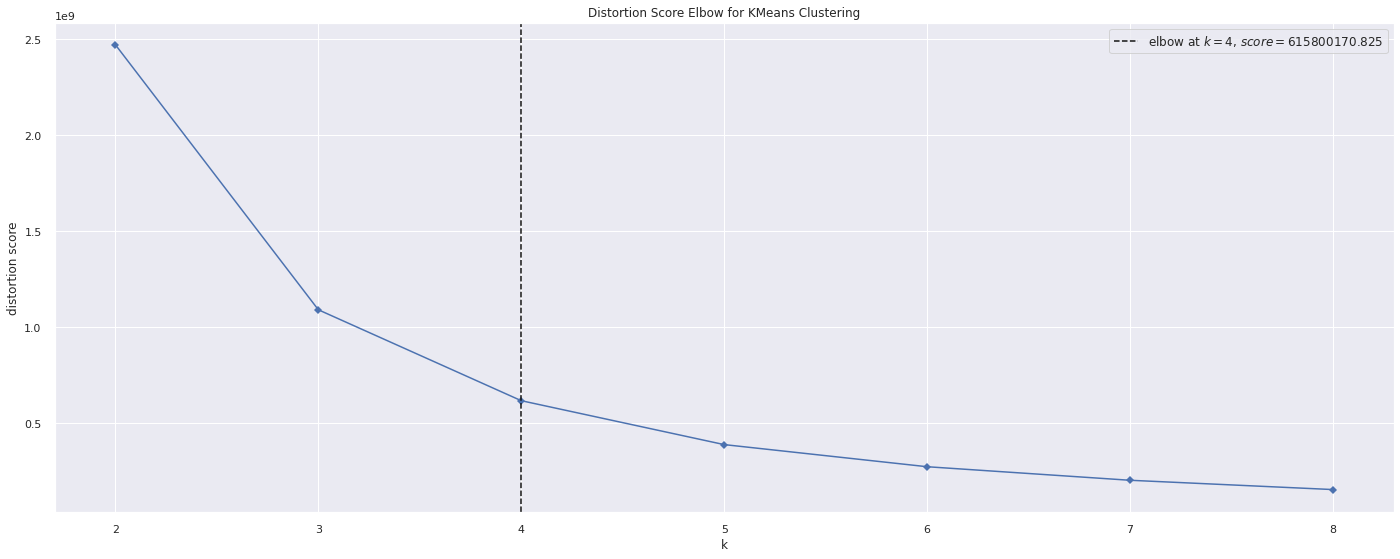

In [189]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False )
kmeans.fit( X )
kmeans.show();

## 5.2. Silhouette Score

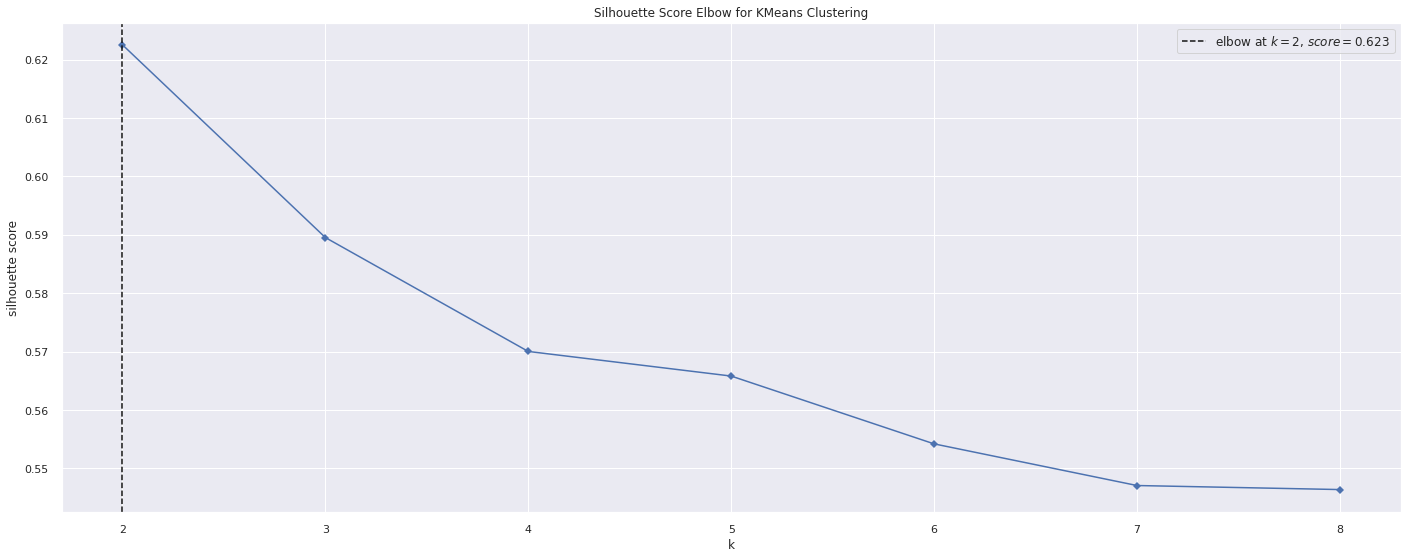

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [190]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit( X )
kmeans.show()

## 5.3. Silhouette Analysis

IndexError: index 3 is out of bounds for axis 0 with size 3

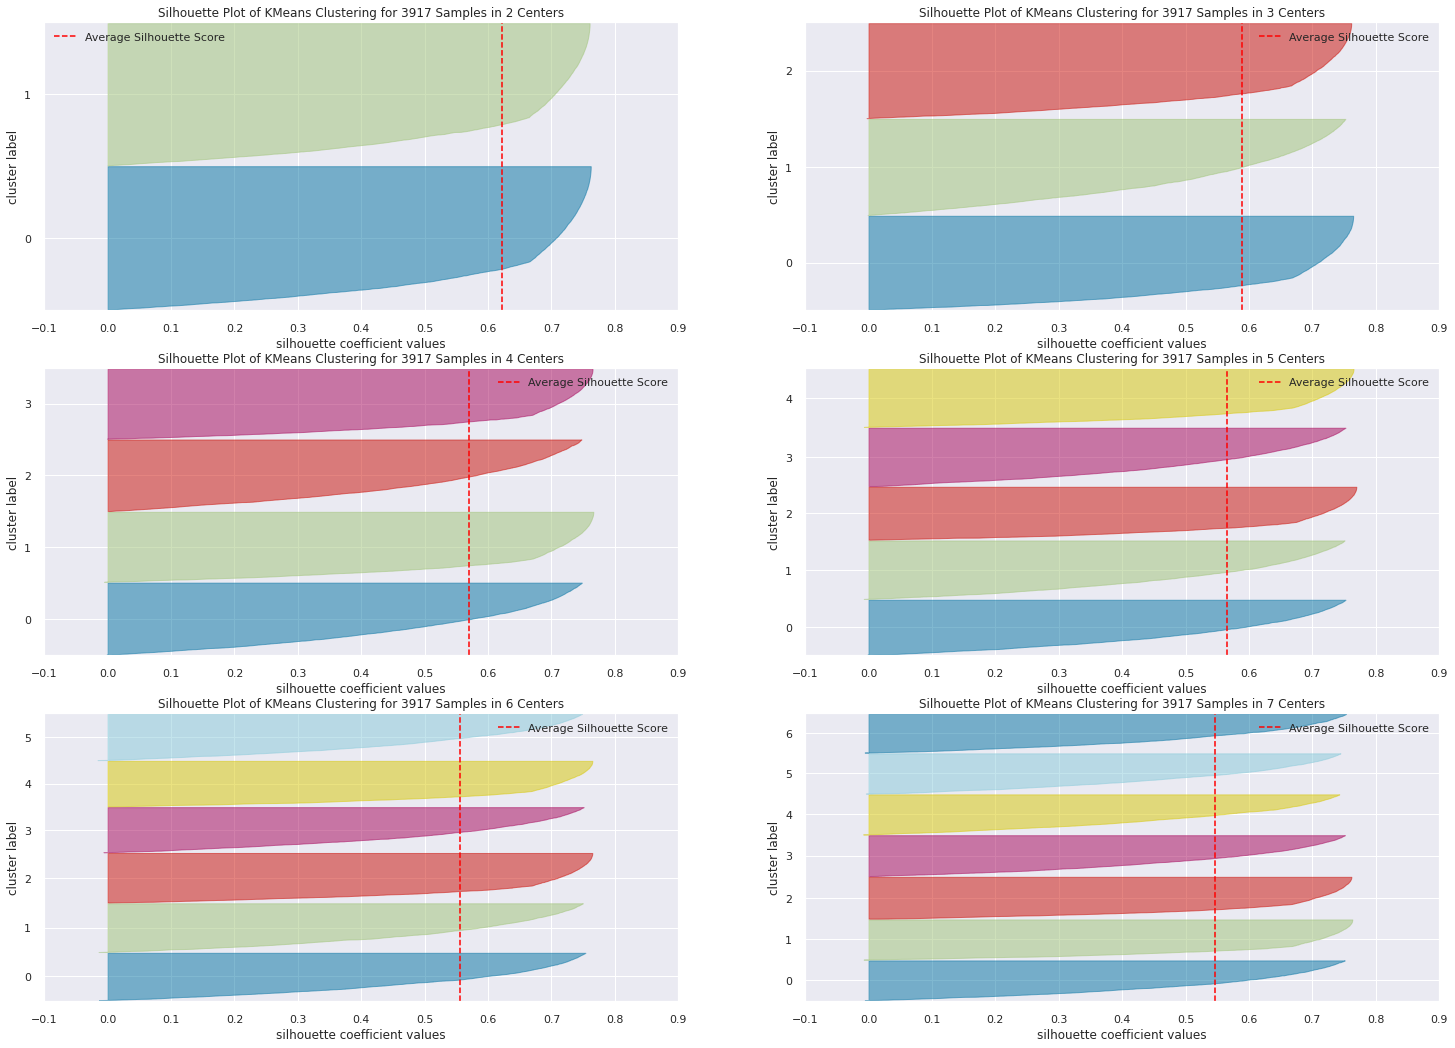

In [191]:
fig, ax = plt.subplots( 3, 2, figsize=(25, 18) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

# 6.0. Model Training 

## 6.1. K-Means

In [192]:
# model definition
k = 8
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300 )

# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_

## 6.2. Cluster Validation

In [193]:
## WSS ( Within-cluster sum of square)
print( 'WSS value: {}'.format( kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS value: 152761215.11330456
SS value: 0.5463712851354298


# 7.0 Cluster Analysis 

In [194]:
df7 = df4.copy()
df7['cluster'] = labels
df7.head()

,customer_id,monetary,recency,frequency,qtde_products,cluster
0,17850,5391.21,365,34,297,4
1,13047,3222.24,30,10,171,5
2,13748,948.25,91,5,28,7
3,15100,876.00,334,3,3,2
4,15291,4668.30,30,15,103,2


## 7.1. Visualization Inspection

/opt/anaconda/envs/manfing/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


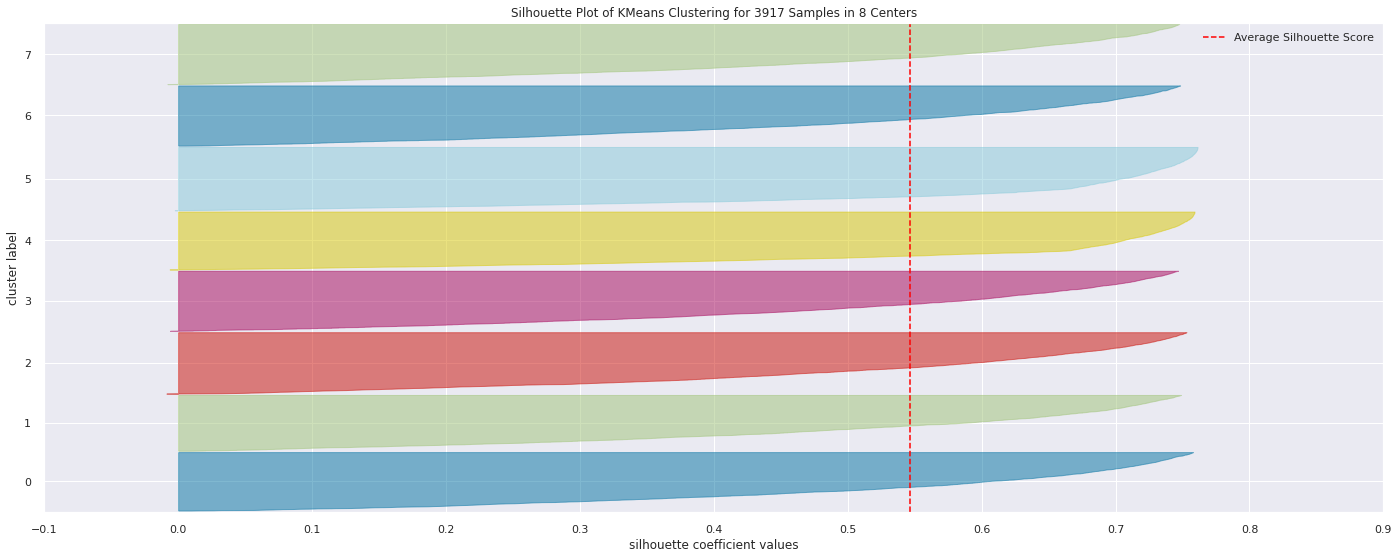

In [195]:
visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
visualizer.fit( X )
visualizer.finalize()

## 7.2. 2d plot

In [196]:
df_viz = df7.drop( columns='customer_id', axis=1 )
#sns.pairplot( df_viz, hue='cluster' )

## 7.3. UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

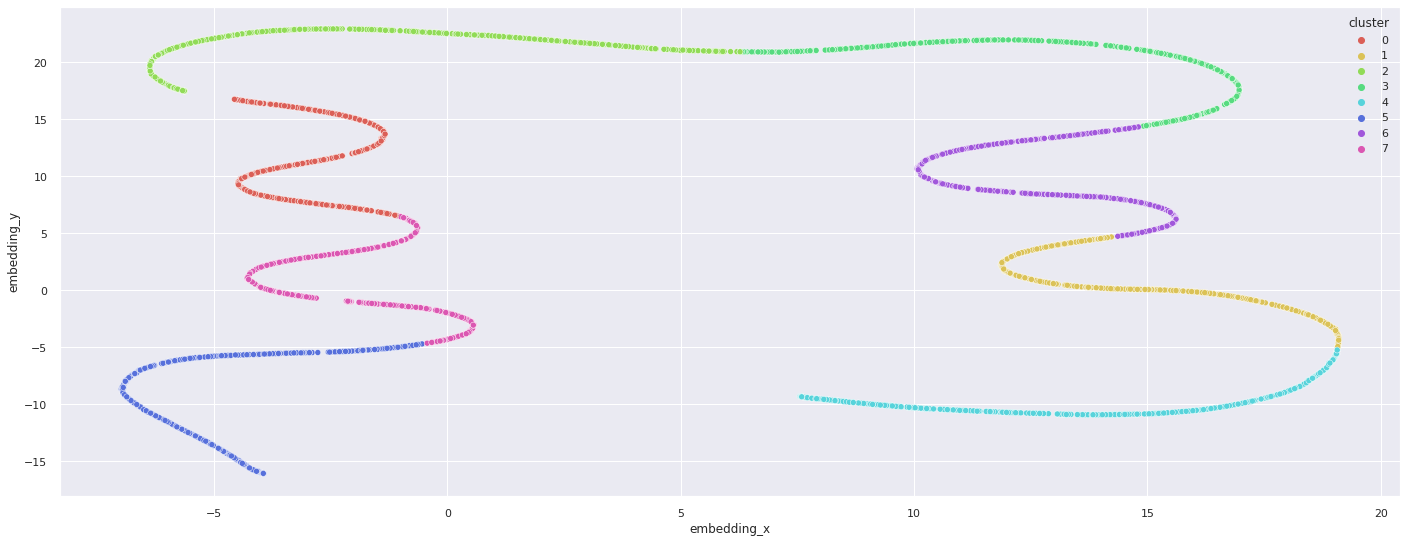

In [197]:
reducer = umap.UMAP( n_neighbors=90, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz )

## 7.4. Cluster Profile

In [198]:
df7.head()

,customer_id,monetary,recency,frequency,qtde_products,cluster
0,17850,5391.21,365,34,297,4
1,13047,3222.24,30,10,171,5
2,13748,948.25,91,5,28,7
3,15100,876.00,334,3,3,2
4,15291,4668.30,30,15,103,2


In [199]:
# Number of customer
df_cluster = df7[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg bill_no
df_invoice_no = df7[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df7[['recency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg Gross revenue
df_avg_gross_revenue = df7[['monetary', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

df_cluster.sort_values( 'monetary', ascending=False)

,cluster,customer_id,perc_customer,frequency,recency,monetary
5,5,519,13.249936,4.865125,96.622351,2043.647977
7,7,494,12.611693,4.246964,96.868421,1869.435304
3,3,493,12.586163,3.821501,101.488844,1791.545923
2,2,504,12.866990,4.057540,103.644841,1704.971349
1,1,458,11.692622,3.917031,91.777293,1572.232620
4,4,475,12.126628,4.421053,104.088421,1532.905642
0,0,480,12.254276,4.264583,92.052083,1530.715604
6,6,494,12.611693,4.103239,95.263158,1514.452126
